# Week 4 Assignment: NLP Disaster Tweets Kaggle Mini-Project

The goal of this project is to classify tweets as either disaster-related or non-disaster-related. This will be achieved using deep learning Recurrent Neural Networks (RNNs) and Natural Language Processing (NLP) techniques. We will be working with the ["Natural Language Processing with Disaster Tweets"](https://www.kaggle.com/c/nlp-getting-started/data) dataset from Kaggle.  The project involves converting tweets into a format understandable by our model, training a series of RNNs to identify the best architecture for this classification task, and comparing its performance against several supervised learning models. Model performance will be evaluated using metrics such as accuracy and F1-score, the latter being the primary metric as it is the standard for judging performance in the Kaggle competition.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Deep Learning Model Layes
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding,GRU, Dense
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Conv1D
from tensorflow.keras.layers import Dropout, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Supervised Learning Models
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from tensorflow.keras.metrics import F1Score

# Preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# NLP
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from wordcloud import WordCloud, STOPWORDS

# Set up environment (for Colab)
tf.compat.v1.enable_eager_execution()
tf.data.experimental.enable_debug_mode()

pd.set_option("display.max_colwidth", 150)

#print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.19.0
3.9.0


# Data Inspection

We began by loading the Kaggle "Natural Language Processing with Disaster Tweets" dataset. The training set contains 7,613 tweets, each labeled as disaster-related (`target=1`) or not (`target=0`), while the test set has 3,263 tweets.

A preview of the data shows each tweet includes optional `keyword` and `location` fields, both of which have many missing values. There are 221 unique keywords and over 3,000 unique locations. The `text` and `target` columns are complete.

In [4]:
base = "nlp-getting-started/"
df_train = pd.read_csv(base + "train.csv")
df_test = pd.read_csv(base + "test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [8]:
display(df_train.isnull().sum())
display(df_test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
print(f"Number of unique keywords: {df_train['keyword'].nunique()}")
print(f"Number of unique locations: {df_train['location'].nunique()}")

Number of unique keywords: 221
Number of unique locations: 3341


# Cleaning

To prepare the tweets for modeling, we applied several text cleaning steps. First, contractions are expanded (e.g., "can't" → "cannot") for consistency. URLs, usernames, and hashtags are removed or normalized, and text is converted to lowercase. We strip out digits, punctuation, and the HTML entity "amp". The text is then tokenized, stopwords are removed, and each word is lemmatized to its base form to reduce inflectional variation.

After cleaning, we check for duplicate tweets. Duplicates with the same label are dropped to avoid bias, and tweets with conflicting labels are removed entirely to ensure label consistency.

In [ ]:
def clean_text(text):
    # Expand contractions (e.g., "I'm" → "I am")
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Split CamelCase
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

    # Lowercase
    text = text.lower()

    # Remove usernames (e.g., @user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags but keep the word (e.g., "#fire" → "fire")
    text = re.sub(r'#', '', text)

    # Remove $amp
    text = re.sub(r'\bamp\b', '', text)

    # Remove digits and punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords (optional)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize (optional but helps LSTM generalize)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    # Join tokens back into a string
    text = ' '.join(tokens)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def get_wordnet_pos(word):
    """Map POS tag to first character for WordNetLemmatizer"""
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].lower()
    return {'n': wordnet.NOUN, 'v': wordnet.VERB, 'a': wordnet.ADJ, 'r': wordnet.ADV}.get(tag, wordnet.NOUN)

df_train['clean_text'] = df_train['text'].apply(lambda text: clean_text(text))
df_test['clean_text'] = df_test['text'].apply(lambda text: clean_text(text))

In [11]:
print("duplicated tweet & target: ", df_train[['clean_text', 'target']].duplicated().sum())
print("duplicated tweets: ", df_train[['clean_text']].duplicated().sum())

print(f"df size before dupe removal: {df_train.shape[0]}")

# Drop duplicates that have the same target
df_train = df_train.drop_duplicates(subset=['clean_text', 'target'], keep='first')

# Identify conflicting 'clean_text' entries with different 'target' values
df_conflicts = df_train.groupby('clean_text').filter(lambda x: x['target'].nunique() > 1)

# Remove these conflicting rows from df_train
df_train = df_train[~df_train['clean_text'].isin(df_conflicts['clean_text'])]

print(f"df size after dupe removal: {df_train.shape[0]}")

duplicated tweet & target:  712
duplicated tweets:  797
df size before dupe removal: 7613
df size after dupe removal: 6731


# EDA

Exploratory Data Analysis (EDA) helps us understand the cleaned dataset and informs feature engineering and modeling.

1.  **Word Clouds for Disaster and Non-Disaster Tweets:** (See Word Clouds plot) These visualize the most frequent words in each class, highlighting terms like "fire," "emergency," and "evacuate" for disaster tweets, and more generic or unrelated words for non-disaster tweets. This helps identify class-specific vocabulary, guiding the decision to use keywords as a feature and to filter out common words that appear in both classes.
2.  **Target Variable Distribution (Count Plot):** (See Count Plot) The count plot shows the number of disaster (target=1) and non-disaster (target=0) tweets. The classes are slightly imbalanced, with more non-disaster tweets. Recognizing this imbalance is important for model training, leading to the use of class weighting during RNN training.
3.  **Boxplot of Character Length by Target:** (See Boxplot) This plot compares tweet lengths across classes, showing that disaster tweets tend to have a slightly higher median character count than non-disaster tweets. This suggests that tweet length could be a useful feature for classification and supports using tokenization and padding which implicitly handle length.
4.  **Histograms of Character and Word Count by Target:** (See Histograms) Histograms display the distribution of tweet lengths (in characters and words) for each class. There is overlap, but disaster tweets are more likely to be longer. This insight supports the inclusion of length-based considerations in preprocessing and model architecture.
5.  **Top Keyword Frequencies (Bar Plot):** (See Keyword Frequency plot) The bar plot of the top 20 keywords shows that certain keywords, such as "fatalities," "damage," and "evacuation," are much more frequent and often associated with disaster tweets. This strongly supports the decision to include keywords as a feature by prepending them to the tweet text.
6.  **Stacked Bar Plot of Top Keywords by Disaster Proportion:** (See Stacked Bar Plot) This visualization shows how often each of the top 50 keywords appears in disaster versus non-disaster tweets. Some keywords are strong indicators of disasters, further supporting their use as predictive features.
7.  **Proportion of Tweets with URLs by Target:** (See URL Proportion plot) A bar plot compares the proportion of tweets containing URLs in each class. Disaster tweets are slightly more likely to include URLs, indicating that URL presence could potentially be used as a binary feature (although this was not explicitly added as a separate feature in the final models, the cleaning process handles URLs).

These analyses help identify informative features, address class imbalance, and guide preprocessing and model selection for improved performance.

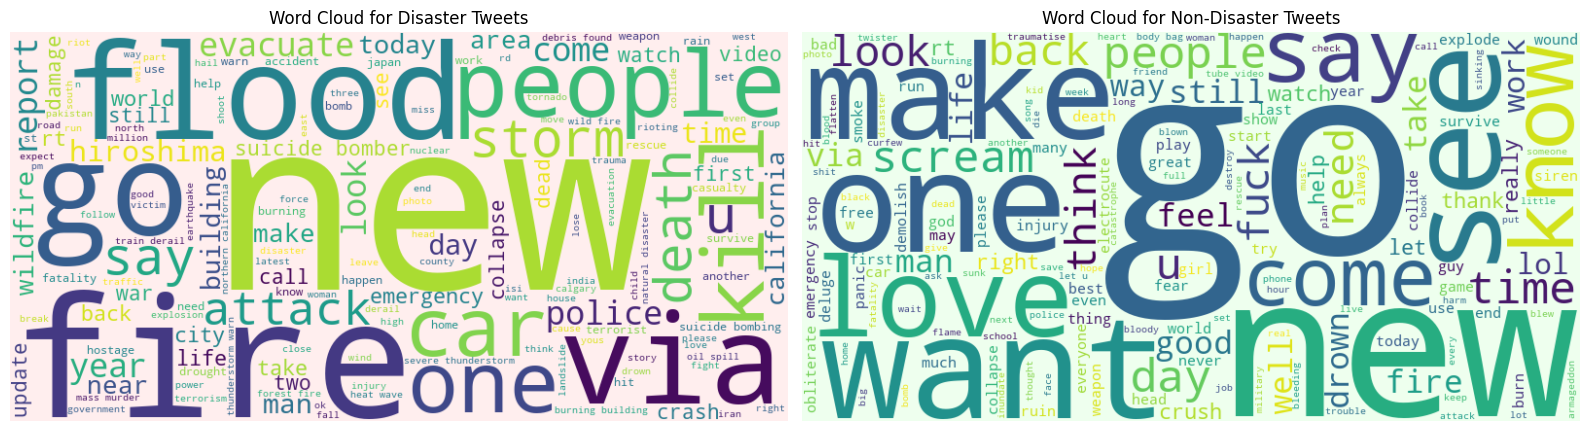

In [ ]:
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Word cloud for disaster tweets
disaster_text = ' '.join(df_train[df_train['target'] == 1]['clean_text'].astype(str).tolist())
wordcloud_disaster = WordCloud(width=800, height=400,
                                background_color='#FFEEEE',  # Word cloud background
                                stopwords=STOPWORDS,
                                min_font_size=10).generate(disaster_text)

# Display the disaster word cloud in the first subplot
ax1.imshow(wordcloud_disaster, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Word Cloud for Disaster Tweets')
ax1.set_facecolor('#FFEEEE') # Set background color for the first axes

# Word cloud for non-disaster tweets
nondisaster_text = ' '.join(df_train[df_train['target'] == 0]['clean_text'].astype(str).tolist())
wordcloud_nondisaster = WordCloud(width=800, height=400,
                                   background_color='#EEFFEE',  # Word cloud background
                                   stopwords=STOPWORDS,
                                   min_font_size=10).generate(nondisaster_text)

# Display the non-disaster word cloud in the second subplot
ax2.imshow(wordcloud_nondisaster, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Word Cloud for Non-Disaster Tweets')
ax2.set_facecolor('#EEFFEE') # Set background color for the second axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

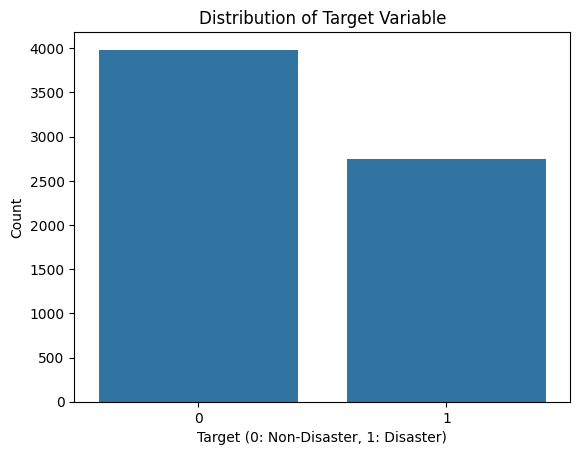

In [ ]:
# Create the count plot
sns.countplot(x='target', data=df_train)

# Customize the plot
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Non-Disaster, 1: Disaster)')
plt.ylabel('Count')

# Show the plot
plt.show()

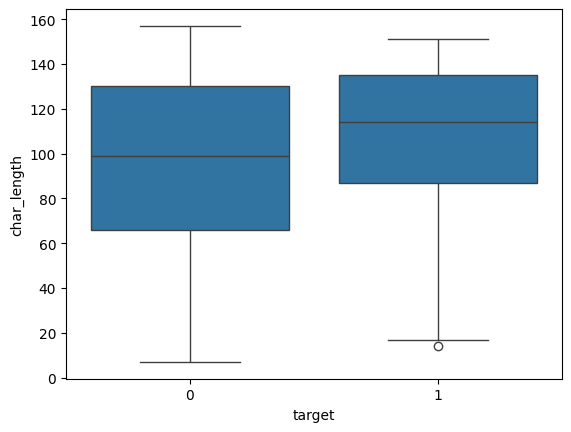

In [14]:
df_train['char_length'] = df_train['text'].apply(lambda x: len(x))
df_train['word_length'] = df_train['text'].apply(lambda x: len(x.split()))

sns.boxplot(x='target', y='char_length', data=df_train)
plt.show()

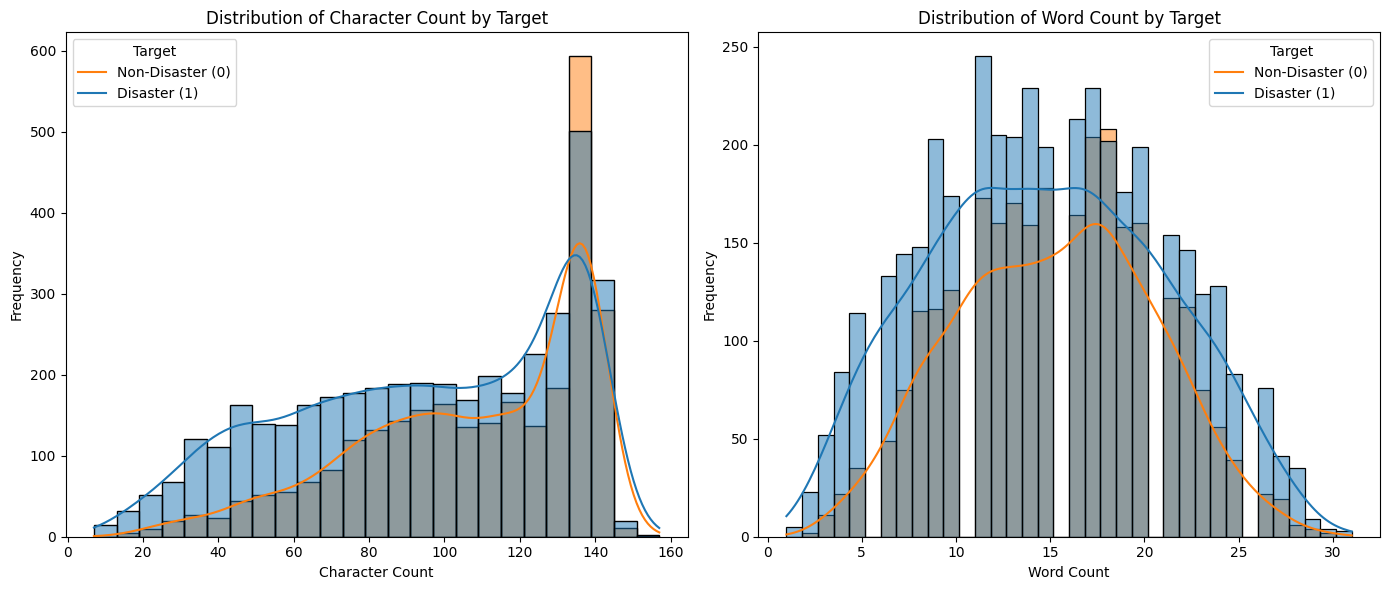

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Adjust figsize as needed

# Histogram of Character Length
sns.histplot(data=df_train, x='char_length', hue='target', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Character Count by Target')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Target', labels=['Non-Disaster (0)', 'Disaster (1)'])

# Histogram of Word Length
sns.histplot(data=df_train, x='word_length', hue='target', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Word Count by Target')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].legend(title='Target', labels=['Non-Disaster (0)', 'Disaster (1)'])

plt.tight_layout()
plt.show()

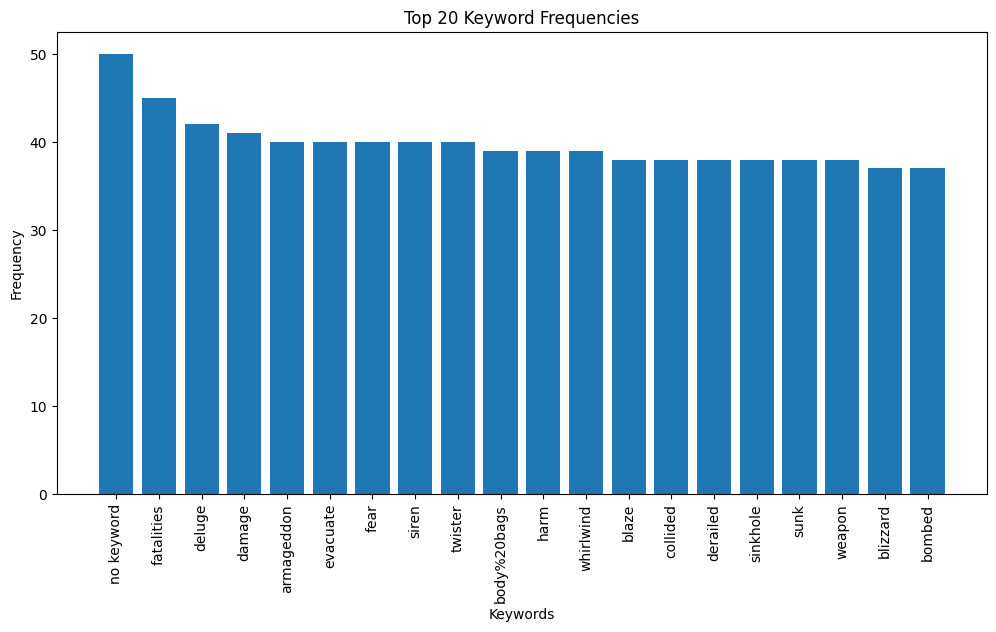

In [16]:
from collections import Counter

# Assuming 'keyword' is a column in your DataFrame
keywords = df_train['keyword'].fillna('no keyword').tolist()  # Replace NaN with 'no_keyword'
keyword_counts = Counter(keywords)

# Get the most common keywords and their counts
top_keywords = keyword_counts.most_common(20)  # Adjust the number as needed
keyword_labels, keyword_frequencies = zip(*top_keywords)

plt.figure(figsize=(12, 6))
plt.bar(keyword_labels, keyword_frequencies)
plt.xticks(rotation=90)
plt.title('Top 20 Keyword Frequencies')
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.show()

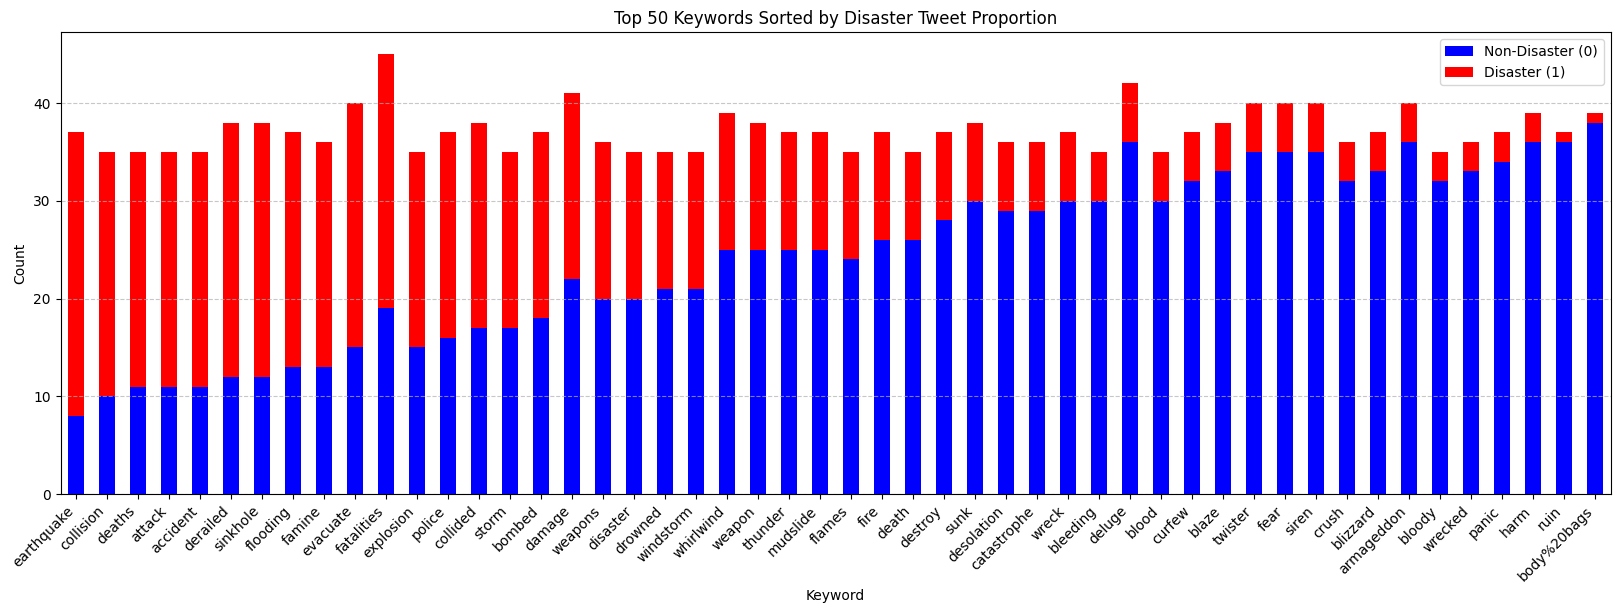

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the most frequent keywords
top_keywords = df_train['keyword'].value_counts().head(50).index

# Filter dataset for only those keywords
filtered_df = df_train[df_train['keyword'].isin(top_keywords)]

# Compute disaster proportions
keyword_counts = filtered_df.groupby(['keyword', 'target']).size().unstack(fill_value=0)

# Add column for disaster proportion
keyword_counts['disaster_proportion'] = keyword_counts[1] / (keyword_counts[0] + keyword_counts[1])

# Sort by disaster proportion in descending order
keyword_counts_sorted = keyword_counts.sort_values(by='disaster_proportion', ascending=False).drop(columns=['disaster_proportion'])

# Plot the bar chart (stacked)
ax = keyword_counts_sorted.plot(kind='bar', stacked=True, figsize=(20, 6), color=['blue', 'red'])

# Customize plot
plt.title("Top 50 Keywords Sorted by Disaster Tweet Proportion")
plt.xlabel("Keyword")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(["Non-Disaster (0)", "Disaster (1)"])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# RNN Models

## Preprocessing

For RNN preprocessing, several steps are applied to optimize input for deep learning models. First, the "keyword" field is cleaned, then, if present, the keyword is attached to the beginning of each tweet's cleaned text. This leverages the fact that certain keywords are strong predictors of disaster tweets, as we discovered during our EDA.

Next, common words that appear with nearly equal frequency in both disaster and non-disaster tweets are identified and removed, as they are unlikely to help the model distinguish between classes. This is done by calculating the proportion of each word's occurrence in both classes and filtering out those with proportions centered around 50% (0.3 to 0.7). Removing common words could reduce the generalizability of our models to unseen tweets, but upon testing the models with and without these words, performance was improved on the training validation set with these words removed. The Kaggle test score also improved.

The cleaned text is then tokenized using a Keras Tokenizer, limited to the top 10,000 words, and converted into sequences of integers. These sequences are padded to a uniform maximum length, ensuring consistent input shape for the RNN. The data is split into training and validation sets.

In [18]:
df_train['keyword'] = df_train['keyword'].str.replace('%20', '')
#df_train['keyword'] = df_train['keyword'].fillna('None')
df_test['keyword'] = df_test['keyword'].str.replace('%20', '')
#df_test['keyword'] = df_test['keyword'].fillna('None')

df_train["clean_text"] = df_train.apply(
    lambda row: f"{row['keyword'].replace(' ', '')} {row['clean_text']}" if pd.notna(row['keyword']) else row['clean_text'], axis=1
)

df_test['clean_text'] = df_test.apply(
    lambda row: f"{row['keyword'].replace(' ', '')} {row['clean_text']}" if pd.notna(row['keyword']) else row['clean_text'], axis=1
)

In [19]:
from collections import Counter

disaster_text = ' '.join(df_train[df_train['target'] == 1]['clean_text'].astype(str).tolist())
nondisaster_text = ' '.join(df_train[df_train['target'] == 0]['clean_text'].astype(str).tolist())

# Count occurrences of each word
d_counter = Counter(disaster_text.split())
nd_counter = Counter(nondisaster_text.split())

# Find common words between both texts
all_words = set(d_counter.keys()).intersection(nd_counter.keys())

# Calculate proportion for each common word
word_props = {word: d_counter[word] / (d_counter[word] + nd_counter[word]) for word in all_words}

# Filter words where proportion is near 50%
filter_words = [word for word, prop in word_props.items() if 0.3 < prop < 0.7]


print("Number of filtered words:", len(filter_words))
total_filters = [d_counter[word] + nd_counter[word] for word in filter_words]
print("Filtered word occurences:", sum(total_filters))
print("Total word occurrences:", sum(len(row['clean_text'].split()) for _, row in df_train.iterrows()))

df_train['clean_text'] = df_train['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if word not in filter_words))
print("Total word occurrences:", sum(len(row['clean_text'].split()) for _, row in df_train.iterrows()))


Number of filtered words: 2071
Filtered word occurences: 26626
Total word occurrences: 65986
Total word occurrences: 39360


In [20]:
vocab_size = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['clean_text'])

train_sequences = tokenizer.texts_to_sequences(df_train['clean_text'])
test_sequences = tokenizer.texts_to_sequences(df_test['clean_text'])

max_length = max(len(seq) for sequences in [train_sequences, test_sequences] for seq in sequences)
train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

X_train, X_val, y_train, y_val = train_test_split(train_sequences, df_train['target'], test_size=0.2, random_state=42)
X_test = test_sequences

In [21]:
# Model hyperparameters
#vocab_size = len(tokenizer.word_index) + 1
print(f"Tokenizer Vocabulary Size: {len(tokenizer.word_index) + 1}")
embedding_dim = 1028
rnn_units = 64
dense_units = 128
dense_dropout = 0.3

# Training hyperparameters
epochs = 50
learning_rate = 0.00005
patience = 3
batch_size = 32
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

# Dictionary to keep models for analysis
rnn_models = dict()

# Helper functions

# Insert RNN layers into sequential neural network
def build_rnn(rnn_layers, name=None, learning_rate=learning_rate):
    # Prepare input
    input = tf.keras.layers.Input(shape=(max_length,))
    embed = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(input)

    # Insert RNN layer(s)
    x = embed
    for rnn_layer in rnn_layers:
        x = rnn_layer(x)

    # Prepare Dense / Output layers
    dense = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    drop = tf.keras.layers.Dropout(dense_dropout)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)

    model = tf.keras.models.Model(inputs=input, outputs=output, name=name)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    model.summary()
    return model

# Train the model
def train_rnn(model, X_train=X_train, y_train=y_train, epochs=epochs, batch_size=batch_size, patience=patience):
    early_stop = EarlyStopping(monitor='val_loss', mode='auto', patience=patience, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[early_stop]
    )
    return model

# Evaluate the model and visualize
def evaluate_model(model, X=X_val, y=y_val):
    y_pred = (model.predict(X, verbose=0)>0.5).astype(int)
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()


Tokenizer Vocabulary Size: 10551


## RNN Building and Training

We built and trained several Recurrent Neural Network (RNN) models to classify tweets, leveraging the sequential nature of text data. These models incorporate an **Embedding layer** to represent words as vectors and **Dense layers** for classification. The architectures fall into two categories: **sequential models (1–6)**, which process text step by step, and **parallel models (7–10)**, which combine multiple layers to extract different features simultaneously.

While training these models was computationally intensive, extensive experimentation was conducted to optimize performance. Each architecture was trained with multiple configurations, varying hyperparameters such as batch size, learning rate, layer sizes, and dropout rates. Additionally, different preprocessing choices, including the number of tokenized words and filtered vocabulary, were tested to assess their impact on classification accuracy. Given the sheer number of trial runs, including every iteration within this notebook would make it prohibitively large. The hyperparameters presented here reflect the most effective configurations identified through rigorous testing.

**Sequential Models**

1. **Long Short-Term Memory**  
Long Short-Term Memory (LSTM) networks are designed to handle sequential data by maintaining an internal memory state, allowing them to capture long-range dependencies while mitigating the vanishing gradient problem. Tweets often contain contextual cues spread across multiple words, making LSTMs effective in preserving meaningful relationships within text.

2. **Gated Recurrent Unit**  
Gated Recurrent Units (GRUs) are a variant of RNN with a simpler structure and fewer parameters. This reduces computational overhead while maintaining comparable performance, making them a more efficient alternative for processing sequential text.

3. **Bidirectional Long Short-Term Memory**
Bidirectional Long Short-Term Memory (Bi-LSTM) networks process text in both forward and backward directions, improving the model’s ability to understand word relationships by incorporating both future and past context. This bidirectional approach enhances text classification by capturing nuances often missed in standard LSTMs.

4. **Bidirectional Gated Recurrent Unit**  
Bidirectional Gated Recurrent Units (Bi-GRU) function similarly to the Bi-LSTM but uses GRU cells, offering efficiency benefits while maintaining the bidirectional context awareness. This model balances computational cost and sequential learning.

5. **Convolutional Neural Network → Bidirectional Long Short-Term Memory**  
Convolutional Neural Networks (CNNs) extract local features from text, before passing them to a Bi-LSTM. This combination allows the model to capture both local patterns and long-range dependencies, improving classification performance.

6. **Convolutional Neural Network → Bidirectional Gated Recurrent Unit**  
This variation replaces the Bi-LSTM with a Bi-GRU while maintaining the Convolutional Neural Network feature extraction step. It retains bidirectional sequential processing but with a lighter architecture, potentially reducing training time.

**Parallel Models**

7. **Long Short-Term Memory + Gated Recurrent Unit**  
This model integrates both LSTM and GRU layers in parallel, potentially allowing the network to leverage the strengths of each. Combining these architectures could potentially leverage the strengths of both in terms of identifing sequential features.

8. **Bidirectional Long Short-Term Memory + Bidirectional Gated Recurrent Unit**  
Bidirectional versions of Long Short-Term Memory and Gated Recurrent Unit networks are combined in a single parallel architecture to enhance sequential feature extraction, leveraging both bidirectional memory structures for improved text representation.

9. **Convolutional Neural Network + Long Short-Term Memory + Gated Recurrent Unit**  
A Convolutional Neural Network extracts local patterns, while both Long Short-Term Memory and Gated Recurrent Unit layers extract sequential features. This approach aims to combine local feature detection with sequential memory retention, providing a multi-layered feature extraction mechanism.

10. **Convolutional Neural Network + Bidirectional Long Short-Term Memory + Bidirectional Gated Recurrent Unit**  
The most complex model tested, integrating a Convolutional Neural Network with both Bidirectional Long Short-Term Memory and Bidirectional Gated Recurrent Unit layers. This setup merges local feature extraction with comprehensive bidirectional sequence processing, allowing the model to capture a wide range of patterns in text classification.

### Model 1: LSTM

In [ ]:
rnn_layers = [
    LSTM(rnn_units)
]

model = build_rnn(rnn_layers, 'LSTM')
model = train_rnn(model)
#evaluate_model(model, X_val, y_val)
rnn_models['LSTM'] = model

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 1028)  │  5,140,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │    279,808 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,428,257 (20.71 MB)

 Trainable params: 5,428,257 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5353 - loss: 0.6917 - val_accuracy: 0.7379 - val_loss: 0.6823
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7902 - loss: 0.6642 - val_accuracy: 0.7988 - val_loss: 0.5827
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8329 - loss: 0.5044 - val_accuracy: 0.8092 - val_loss: 0.4665
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8557 - loss: 0.3962 - val_accuracy: 0.8137 - val_loss: 0.4472
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8798 - loss: 0.3414 - val_accuracy: 0.8099 - val_loss: 0.4566
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8919 - loss: 0.2989 - val_accuracy: 0.8129 - val_loss: 0.4593
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8984 - loss: 0.2706 - val_accuracy: 0.8092 - val_loss: 0.4820


### Model 2: GRU

In [23]:
rnn_layers = [
    tf.keras.layers.GRU(rnn_units)
]

model = build_rnn(rnn_layers, name='GRU')
model = train_rnn(model)
#evaluate_model(model, X_val, y_val)
rnn_models['GRU'] = model

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 24, 1028)  │  5,140,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 24)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │    210,048 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,358,497 (20.44 MB)

 Trainable params: 5,358,497 (20.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.4468 - loss: 0.6930 - val_accuracy: 0.5702 - val_loss: 0.6882
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6856 - loss: 0.6763 - val_accuracy: 0.7298 - val_loss: 0.6524
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8142 - loss: 0.5958 - val_accuracy: 0.8048 - val_loss: 0.4863
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8503 - loss: 0.3987 - val_accuracy: 0.8151 - val_loss: 0.4319
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8788 - loss: 0.3291 - val_accuracy: 0.8159 - val_loss: 0.4346
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8957 - loss: 0.2851 - val_accuracy: 0.8122 - val_loss: 0.4484
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9090 - loss: 0.2420 - val_accuracy: 0.8122 - val_loss: 0.4674


### Model 3: Bidirectional LSTM

In [ ]:
rnn_layers = [
    tf.keras.layers.Bidirectional(LSTM(rnn_units))
]

model = build_rnn(rnn_layers, name='BD-LSTM')
model = train_rnn(model)
#evaluate_model(model, X_val, y_val)
rnn_models['BiLSTM'] = model

Model: "BD-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 24, 1028)  │  5,140,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 24)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    559,616 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,716,257 (21.81 MB)

 Trainable params: 5,716,257 (21.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.6184 - loss: 0.6902 - val_accuracy: 0.7543 - val_loss: 0.6757
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7896 - loss: 0.6553 - val_accuracy: 0.8025 - val_loss: 0.5784
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8318 - loss: 0.5107 - val_accuracy: 0.8114 - val_loss: 0.4455
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.8616 - loss: 0.3627 - val_accuracy: 0.8189 - val_loss: 0.4358
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8805 - loss: 0.3116 - val_accuracy: 0.8189 - val_loss: 0.4437
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8976 - loss: 0.2676 - val_accuracy: 0.8129 - val_loss: 0.4675
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9053 - loss: 0.2419 - val_accuracy: 0.8077 - val_loss: 0.4915


### Model 4: Bidirectional GRU

In [25]:
rnn_layers = [
    tf.keras.layers.Bidirectional(GRU(rnn_units))
]

model = build_rnn(rnn_layers, name='BD-GRU')
model = train_rnn(model)
#evaluate_model(model, X_val, y_val)
rnn_models['BiGRU'] = model

Model: "BD-GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 24, 1028)  │  5,140,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 24)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    420,096 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,576,737 (21.27 MB)

 Trainable params: 5,576,737 (21.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.5489 - loss: 0.6910 - val_accuracy: 0.7201 - val_loss: 0.6788
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7663 - loss: 0.6648 - val_accuracy: 0.7825 - val_loss: 0.6033
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8207 - loss: 0.5362 - val_accuracy: 0.8048 - val_loss: 0.4635
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8560 - loss: 0.3756 - val_accuracy: 0.8159 - val_loss: 0.4264
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8770 - loss: 0.3086 - val_accuracy: 0.8196 - val_loss: 0.4330
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9051 - loss: 0.2557 - val_accuracy: 0.8189 - val_loss: 0.4509
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9165 - loss: 0.2298 - val_accuracy: 0.8077 - val_loss: 0.4821


### Model 5: CNN -> Bidirectional LSTM

In [26]:
rnn_layers = [
    tf.keras.layers.Conv1D(filters=rnn_units, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(LSTM(rnn_units))
]

model = build_rnn(rnn_layers, 'Conv-BD-LSTM')
model = train_rnn(model)
#evaluate_model(model, X_val, y_val)
rnn_models['CNN > BiLSTM'] = model

c:\python\Python311\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "Conv-BD-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 24, 1028)       │     5,140,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 22, 64)         │       197,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,420,129 (20.68 MB)

 Trainable params: 5,420,129 (20.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4458 - loss: 0.6960 - val_accuracy: 0.7112 - val_loss: 0.6857
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6863 - loss: 0.6792 - val_accuracy: 0.6637 - val_loss: 0.6430
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7869 - loss: 0.5526 - val_accuracy: 0.7550 - val_loss: 0.4973
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8426 - loss: 0.3593 - val_accuracy: 0.7320 - val_loss: 0.5420
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8645 - loss: 0.3072 - val_accuracy: 0.8055 - val_loss: 0.4613
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9070 - loss: 0.2413 - val_accuracy: 0.7765 - val_loss: 0.5241
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9246 - loss: 0.2001 - val_accuracy: 0.7817 - val_loss: 0.5476
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9459 - loss: 0.1535 - val_accu

### Model 6: CNN -> Bidirectional GRU

In [27]:
from tensorflow.keras.regularizers import l2

rnn_layers = [
    tf.keras.layers.Conv1D(filters=rnn_units, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(GRU(rnn_units))
]

model = build_rnn(rnn_layers, name="Conv-BD-GRU")
model = train_rnn(model, epochs=50)
#evaluate_model(model, X_val, y_val)
rnn_models['CNN > BiGRU'] = model

c:\python\Python311\Lib\site-packages\keras\src\layers\layer.py:939: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "Conv-BD-GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 24, 1028)       │     5,140,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │       197,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,404,001 (20.61 MB)

 Trainable params: 5,404,001 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5090 - loss: 0.6923 - val_accuracy: 0.6904 - val_loss: 0.6849
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7110 - loss: 0.6710 - val_accuracy: 0.7906 - val_loss: 0.6030
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8230 - loss: 0.5272 - val_accuracy: 0.8107 - val_loss: 0.4403
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8479 - loss: 0.3650 - val_accuracy: 0.8159 - val_loss: 0.4164
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8939 - loss: 0.2700 - val_accuracy: 0.7899 - val_loss: 0.4612
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9096 - loss: 0.2383 - val_accuracy: 0.8025 - val_loss: 0.4630
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9168 - loss: 0.2089 - val_accuracy: 0.8166 - val_loss: 0.4757


### Model 7: LSTM + GRU

In [28]:
# Input layer
inputs = Input(shape=(max_length,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# RNN Branches
gru = GRU(rnn_units, recurrent_dropout=0.2)(embedding)
lstm = LSTM(rnn_units, recurrent_dropout=0.2)(embedding)

# Concatenation
merged = Concatenate()([gru, lstm])

# Dense Layers
dense = Dense(dense_units, activation='relu')(merged)
dropout = Dropout(dense_dropout)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Model definition
model = Model(inputs, output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_rnn(model, batch_size=128)
rnn_models['LSTM + GRU'] = model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 24, 1028)  │  5,140,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 64)        │    210,048 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │    279,808 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ gru_3[0][0],      │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,646,497 (21.54 MB)

 Trainable params: 5,646,497 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4621 - loss: 0.6941 - val_accuracy: 0.5969 - val_loss: 0.6923
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5358 - loss: 0.6914 - val_accuracy: 0.4031 - val_loss: 0.6949
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4220 - loss: 0.6923 - val_accuracy: 0.4053 - val_loss: 0.6943
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.4717 - loss: 0.6935 - val_accuracy: 0.7402 - val_loss: 0.6905
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.6004 - loss: 0.6894 - val_accuracy: 0.7342 - val_loss: 0.6780
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7153 - loss: 0.6479 - val_accuracy: 0.8003 - val_loss: 0.4772
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.8007 - loss: 0.4818 - val_accuracy: 0.8166 - val_loss: 0.4407
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.8193 - loss: 0.4387 - val_accuracy: 0.8003 - v

### Model 8: BiLSTM + BiGRU

In [29]:
# Input layer
inputs = Input(shape=(max_length,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# RNN Branches
# RNN Branches
gru = Bidirectional(GRU(rnn_units, recurrent_dropout=0.2))(embedding)
lstm = Bidirectional(LSTM(rnn_units, recurrent_dropout=0.2))(embedding)

# Concatenation
merged = Concatenate()([gru, lstm])

# Dense Layers
dense = Dense(dense_units, activation='relu')(merged)
dropout = Dropout(dense_dropout)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Model definition
model = Model(inputs, output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_rnn(model)
rnn_models['BiLSTM + BiGRU'] = model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 24, 1028)  │  5,140,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 128)       │    420,096 │ embedding_7[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │    559,616 │ embedding_7[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ bidirectional_4[… │
│ (Concatenate)       │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,152,737 (23.47 MB)

 Trainable params: 6,152,737 (23.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.5085 - loss: 0.6922 - val_accuracy: 0.7253 - val_loss: 0.6784
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.7410 - loss: 0.6614 - val_accuracy: 0.7803 - val_loss: 0.5836
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8012 - loss: 0.5194 - val_accuracy: 0.7981 - val_loss: 0.4509
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8406 - loss: 0.3820 - val_accuracy: 0.8137 - val_loss: 0.4281
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8641 - loss: 0.3241 - val_accuracy: 0.8114 - val_loss: 0.4318
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.8830 - loss: 0.2794 - val_accuracy: 0.8099 - val_loss: 0.4400
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8953 - loss: 0.2539 - val_accuracy: 0.8107 - val_loss: 0.4501


### Model 9: CNN + LSTM + GRU

In [30]:
# Input layer
inputs = Input(shape=(max_length,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Conv1D Branch
conv1d = Conv1D(filters=rnn_units, kernel_size=3, activation='relu')(embedding)
conv1d_pooled = GlobalMaxPooling1D()(conv1d)

# RNN Branches
gru = GRU(rnn_units, recurrent_dropout=0.2)(embedding)
lstm = LSTM(rnn_units, recurrent_dropout=0.2)(embedding)

# Concatenation
merged = Concatenate()([conv1d_pooled, gru, lstm])

# Dense Layers
dense = Dense(dense_units, activation='relu')(merged)
dropout = Dropout(dense_dropout)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Model definition
model = Model(inputs, output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_rnn(model)
rnn_models['CNN + LSTM + GRU'] = model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 24, 1028)  │  5,140,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 64)    │    197,440 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 64)        │    210,048 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │    279,808 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ gru_5[0][0],      │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     24,704 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        129 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,852,129 (22.32 MB)

 Trainable params: 5,852,129 (22.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.5638 - loss: 0.6896 - val_accuracy: 0.5932 - val_loss: 0.6857
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6757 - loss: 0.6725 - val_accuracy: 0.7669 - val_loss: 0.6473
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8182 - loss: 0.6187 - val_accuracy: 0.7840 - val_loss: 0.5811
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8303 - loss: 0.5114 - val_accuracy: 0.8018 - val_loss: 0.4955
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8629 - loss: 0.4009 - val_accuracy: 0.8114 - val_loss: 0.4466
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8854 - loss: 0.3357 - val_accuracy: 0.8085 - val_loss: 0.4377
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9050 - loss: 0.2753 - val_accuracy: 0.8122 - val_loss: 0.4362
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9159 - loss: 0.2405 - val_acc

### Model 10: CNN + BiLSTM + BiGRU

In [31]:
# Input layer
inputs = Input(shape=(max_length,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Conv1D Branch
conv1d = Conv1D(filters=rnn_units, kernel_size=3, activation='relu')(embedding)
conv1d_pooled = GlobalMaxPooling1D()(conv1d)  # Reducing feature maps to a fixed-length vector

# RNN Branches
gru = Bidirectional(GRU(rnn_units, recurrent_dropout=0.2))(embedding)
lstm = Bidirectional(LSTM(rnn_units, recurrent_dropout=0.2))(embedding)

# Concatenation
merged = Concatenate()([conv1d_pooled, gru, lstm])

# Dense Layers
dense = Dense(dense_units, activation='relu')(merged)
dropout = Dropout(dense_dropout)(dense)
output = Dense(1, activation='sigmoid')(dropout)  # Binary classification

# Model definition
model = Model(inputs, output)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

train_rnn(model)
rnn_models['CNN + BiLSTM + BiGRU'] = model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 24, 1028)  │  5,140,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 22, 64)    │    197,440 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 128)       │    420,096 │ embedding_9[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 128)       │    559,616 │ embedding_9[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 320)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_6[… │
│                     │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     41,088 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │        129 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,358,369 (24.26 MB)

 Trainable params: 6,358,369 (24.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5317 - loss: 0.6929 - val_accuracy: 0.7075 - val_loss: 0.6670
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7357 - loss: 0.6544 - val_accuracy: 0.7780 - val_loss: 0.5919
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8008 - loss: 0.5356 - val_accuracy: 0.7639 - val_loss: 0.4947
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8328 - loss: 0.4060 - val_accuracy: 0.7973 - val_loss: 0.4479
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8521 - loss: 0.3359 - val_accuracy: 0.8137 - val_loss: 0.4332
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8790 - loss: 0.2910 - val_accuracy: 0.8048 - val_loss: 0.4574
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8968 - loss: 0.2572 - val_accuracy: 0.8144 - val_loss: 0.4503
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9047 - loss: 0.2223 - 

## Analysis of RNN Model Performance

To assess the performance of the various RNN architectures, we evaluated several key metrics: Accuracy, F1-score, Precision, and Recall. A bar plot (refer to the "RNN Model Performance Comparison Across Metrics" plot) visualizes these scores across the different models. From this visualization, we can observe variations in performance. For example, the BiLSTM model exhibits the highest F1-score, indicating a good balance between precision and recall. In contrast, the CNN > BiGRU model shows a high precision but lower recall, suggesting it is good at identifying true positives but misses more actual positive cases. The ROC curve plot further illustrates the trade-off between true positive rate and false positive rate for each model. The area under the curve (AUC) provides a single measure of overall performance. The BiLSTM model again demonstrates a high AUC, reinforcing its strong performance. Examining the confusion matrices for the top three models by F1-score (refer to the "Confusion Matrix for top 3 performing models" plots) provides a more detailed breakdown of their predictions, showing the number of true positives, true negatives, false positives, and false negatives. The BiLSTM confusion matrix, for instance, shows a good number of true positives and true negatives relative to false positives and negatives.

Based on the F1-score, the BiLSTM model is identified as the best performing model with an F1-score of 0.7715. This architecture consists of a Bidirectional LSTM layer after the embedding layer. The Bidirectional LSTM layer is likely a key contributor to its success. By processing the text sequence in both forward and backward directions, the model can capture contextual information from both the beginning and end of a tweet, which is particularly beneficial in understanding the nuances of natural language. Another strength lies in its ability to retain long-term dependencies and its bidirectional nature allows for a more complete understanding of the tweet's meaning. Other competitive models include the BiGRU and CNN + LSTM + GRU, which also demonstrate respectable F1-scores and AUC values, suggesting that bidirectional layers and the inclusion of CNN layers can be beneficial.

On the Kaggle competition leaderboard (see kaggle_score.png), the best performing model achieved a respectable public score of 0.78026. This indicates that the chosen model and preprocessing steps were effective in generalizing to unseen data, but improvements could be made.

In [47]:
# Calculate metrics and prepare results for analysis

rnn_results = []
for model_name, model in rnn_models.items():
    #print(f"Model: {model_name}")
    yp = (model.predict(X_val, verbose=0)>0.5).astype(int)
    #print(classification_report(y_val, y_val_pred))
    #print()
    acc = accuracy_score(y_val, yp)
    f1 = f1_score(y_val, yp)
    auc = roc_auc_score(y_val.values, yp)
    prec = precision_score(y_val.values, yp)
    rec = recall_score(y_val.values, yp)
    cm = confusion_matrix(y_val, yp)
    #print(f"{model_name:6}: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}, prec={prec:.3f}, rec={rec:.3f}")
    result = {'name': model_name, 'acc': acc, 'f1': f1, 'auc': auc, 'prec': prec, 'rec': rec, 'cm': cm, 'model': model}
    rnn_results.append(result)

rnn_results_df = pd.DataFrame(rnn_results)
rnn_results_df.drop(columns='model').head(10)

,name,acc,f1,auc,prec,rec,cm
0,LSTM,0.813660,0.763876,0.802953,0.780769,0.747698,"[[690, 114], [137, 406]]"
1,GRU,0.815145,0.766635,0.805094,0.780534,0.753223,"[[689, 115], [134, 409]]"
2,BiLSTM,0.818857,0.771536,0.809100,0.784762,0.758748,"[[691, 113], [131, 412]]"
3,BiGRU,0.815887,0.767790,0.806015,0.780952,0.755064,"[[689, 115], [133, 410]]"
4,CNN > BiLSTM,0.805494,0.766071,0.802988,0.743501,0.790055,"[[656, 148], [114, 429]]"
5,CNN > BiGRU,0.815887,0.753479,0.796748,0.818575,0.697974,"[[720, 84], [164, 379]]"
6,LSTM + GRU,0.816630,0.752257,0.796175,0.825991,0.690608,"[[725, 79], [168, 375]]"
7,BiLSTM + BiGRU,0.813660,0.755122,0.797274,0.802905,0.712707,"[[709, 95], [156, 387]]"
8,CNN + LSTM + GRU,0.812175,0.768950,0.806193,0.762681,0.775322,"[[673, 131], [122, 421]]"
9,CNN + BiLSTM + BiGRU,0.813660,0.760724,0.800861,0.788538,0.734807,"[[697, 107], [144, 399]]"


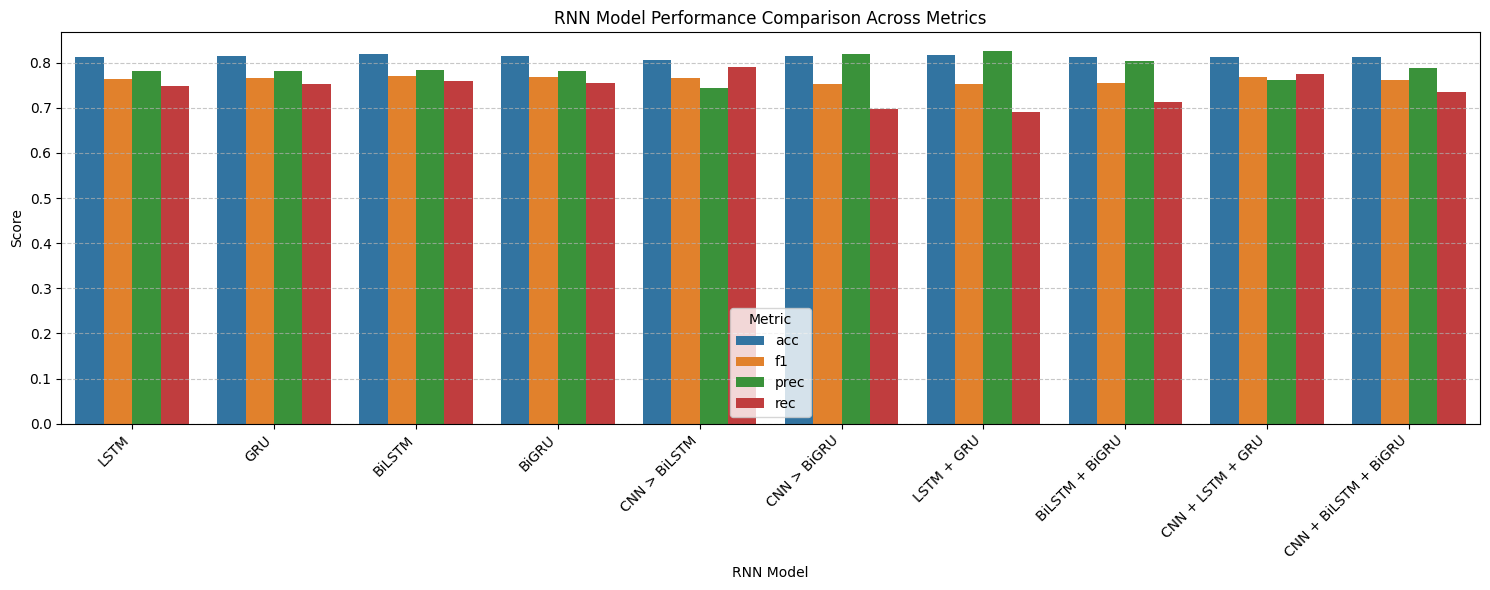

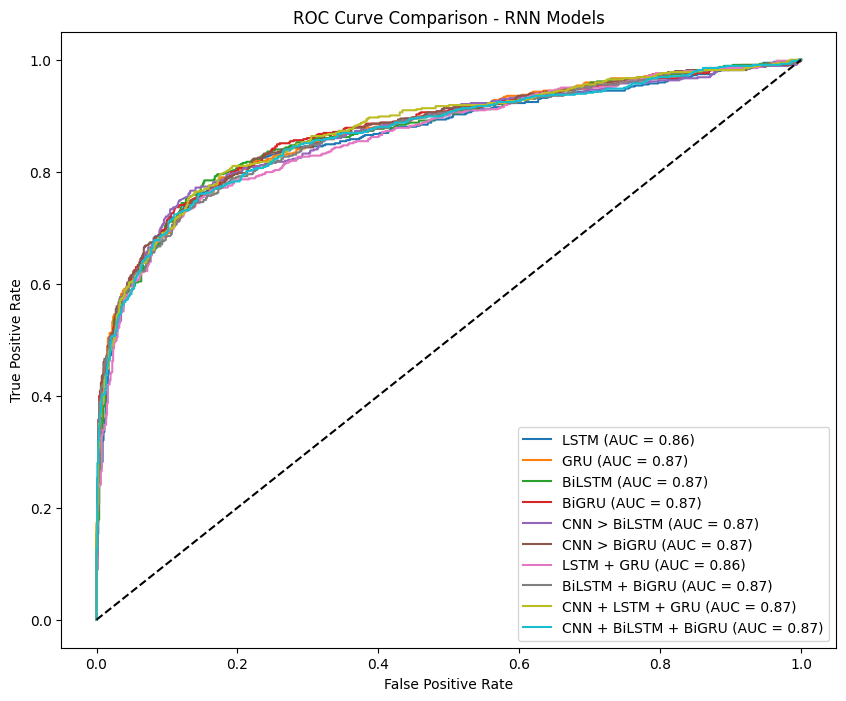

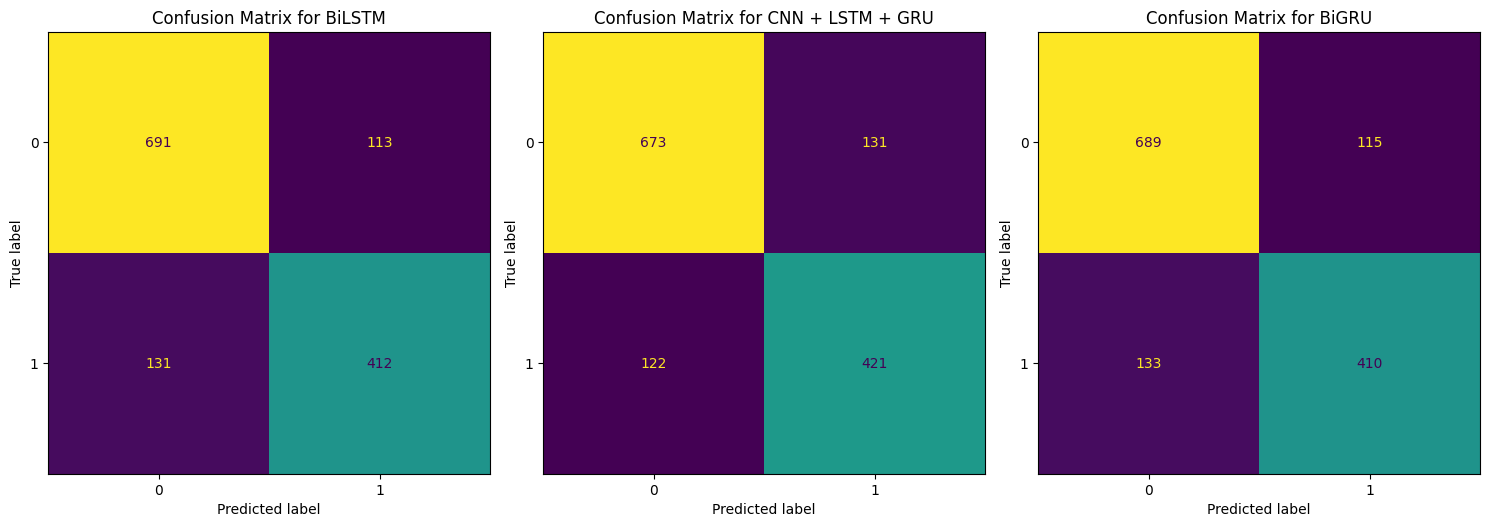

In [33]:
# 1. Bar plot of metrics for rnn models
results_melted_rnn = rnn_results_df.melt(id_vars='name',
                                         value_vars=['acc', 'f1', 'prec', 'rec'],
                                         var_name='Metric',
                                         value_name='Score')

# Create the grouped bar plot for RNN models
plt.figure(figsize=(15, 6)) # Adjust figure size as needed
sns.barplot(x='name', y='Score', hue='Metric', data=results_melted_rnn)

plt.title('RNN Model Performance Comparison Across Metrics')
plt.xlabel('RNN Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
#plt.legend(title='Metric', loc='lower right', bbox_to_anchor=(1, 0))
plt.tight_layout() # Adjust layout
plt.show()


# 2. ROC Curve
plt.figure(figsize=(10, 8))
for index, row in rnn_results_df.iterrows():
    model = row['model']
    model_name = row['name']

    y_pred_prob = model.predict(X_val, verbose=0)

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    auc = roc_auc_score(y_val, y_pred_prob)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - RNN Models')
plt.legend()
plt.show()

# 3. Confusion Matrix for top 3 performing models
top_models = rnn_results_df.sort_values(by='f1', ascending=False).head(3)
num_models = len(top_models)
fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 5))  # Adjust figure size based on model count
fig.subplots_adjust(wspace=0.5)

for index, (ax, row) in enumerate(zip(axes, top_models.iterrows())):
    model_name = row[1]['name']
    cm = row[1]['cm']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')

plt.tight_layout()
plt.show()


The best model is BiLSTM
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       804
           1       0.78      0.76      0.77       543

    accuracy                           0.82      1347
   macro avg       0.81      0.81      0.81      1347
weighted avg       0.82      0.82      0.82      1347



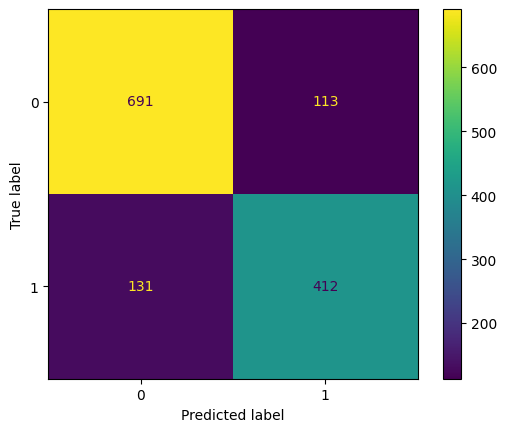

In [34]:
# Find the model with the highest F1-score.

# F1-score is a good measure of the balance between precision and recall.
best_model = rnn_results_df.loc[rnn_results_df['f1'].idxmax()]

print(f"The best model is {best_model['name']}")

evaluate_model(best_model['model'])

# Generate predictions on test set
df_test['target'] = (best_model['model'].predict(test_sequences, verbose=0)>0.5).astype(int)
df_test[['id', 'target']].to_csv('best_predictions.csv', index=False)


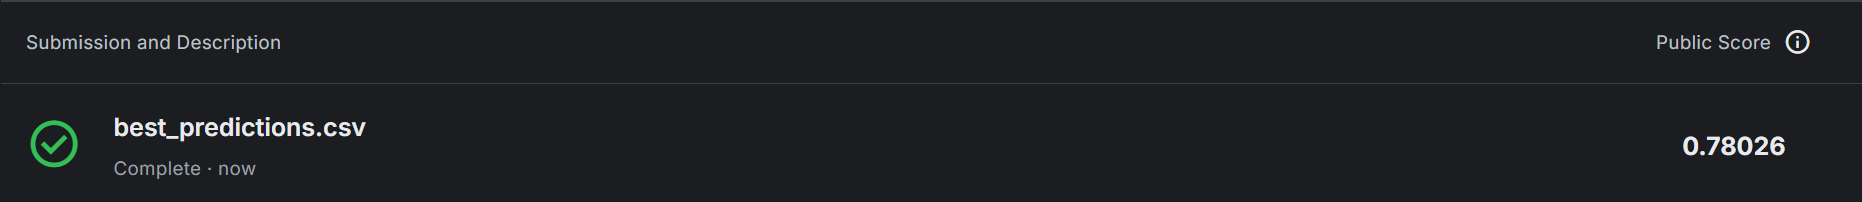

In [46]:
# Kaggle score result
from IPython.display import Image
Image(filename="kaggle_score.png")

# Other models

To compare the performance of the developed RNN models, several traditional supervised learning models were also trained and evaluated on the dataset. These models provide a benchmark to understand how deep learning approaches fare against more classical techniques for this classification task.

## Preprocessing

For traditional supervised learning models, cleaned tweet text was converted into numerical feature vectors using TF-IDF Vectorization. The `TfidfVectorizer` was configured to limit features to the most frequent and ignore terms appearing in fewer than 5 tweets. The resulting feature matrix and target variable were split into training and validation sets (80/20 split). Class weights were computed to address the dataset's class imbalance during model training.

In [36]:
vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1,3), max_features=vocab_size, sublinear_tf=True, min_df=5)
vectorizer = vectorizer.fit(df_train['clean_text'])

vocabulary_shape = vectorizer.vocabulary_
print(f"Vocabulary shape (number of features): {len(vocabulary_shape)}")

X = vectorizer.transform(df_train['clean_text'])#, y=df_train['Category'])
print(df_train.shape[0], X.shape[0])

y = df_train['target']
#df_clean[df_clean['clean_text'].duplicated()][['clean_text', 'target']].head(60)

Vocabulary shape (number of features): 1768
6731 6731


In [37]:
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X, y, train_size=0.8, random_state=42)

class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(y_train_s), y=y_train_s)))

sup_models = dict()

## Building and training

The supervised models used were constructed and trained subsequent to hyperparameter optimization conducted via GridSearchCV. This systematic approach explores a predefined range of hyperparameter values for each model, utilizing cross-validation to identify the configuration that maximizes performance based on a specified scoring metric, in this case, the F1-score. The F1-score was selected as the primary evaluation metric during grid search mainly because the Kaggle contest scoring is based on F1 but also because of its balance between precision and recall.

Models explored:

1.  **Random Forest Classifier (RF):** An ensemble learning method that constructs multiple decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. It is robust to overfitting and can handle a large number of features.

2.  **Support Vector Classifier (SVC):** A supervised learning model used for classification and regression analysis. It finds the optimal hyperplane that best separates data points of different classes in a high-dimensional space.

3.  **XGBoost:** An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements machine learning algorithms under the Gradient Boosting framework.

4.  **Logistic Regression:** A statistical model that uses a logistic function to model a binary dependent variable. It's a linear model that estimates the probability of a binary outcome.

### Random Forest Classifier (RF)

In [38]:
grid_rf = GridSearchCV(
    RandomForestClassifier(class_weight=class_weights, random_state=42),
    param_grid={
        'n_estimators': range(50, 201, 50),
        'max_depth': range(5, 21, 5),
        'min_samples_split': range(2, 6),
        'min_samples_leaf': range(1, 4)
        #'max_features': ['sqrt', 'log2', None]
    },
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train_s, y_train_s)
model_rf = grid_rf.best_estimator_

print(f'Best Parameters: {grid_rf.best_params_}')
print(f'Best score: {grid_rf.best_score_}')

#df_train['rf'] = model_rf.predict(X_)

sup_models['Random Forest'] = model_rf

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.6266150032209827


### Support Vector Classifier (SVC)

In [39]:
grid_svc = GridSearchCV(
    SVC(class_weight=class_weights, random_state=42),
    param_grid={
        'C': [0.5, 1, 2, 5, 10],
        'gamma': [0.1, 0.25, 0.5, 0.75, 1],
        'kernel': ['linear', 'rbf']
    },
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_svc.fit(X_train_s, y_train_s)
model_svc = grid_svc.best_estimator_

print(f'Best Parameters: {grid_svc.best_params_}')
print(f'Best score: {grid_svc.best_score_}')

#df_train['svc'] = model_svc.predict(X)

sup_models['SVC'] = model_svc

Best Parameters: {'C': 1, 'gamma': 0.75, 'kernel': 'rbf'}
Best score: 0.735183072187262


### XGBoost

In [40]:
grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid={
        'n_estimators': [100, 200, 300],  # Number of trees
        'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
        'max_depth': [3, 5, 7],  # Maximum tree depth
        'subsample': [0.8, 1.0],  # Fraction of samples used
        'colsample_bytree': [0.8, 1.0]  # Fraction of features used
    },
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_xgb.fit(X_train_s, y_train_s)
model_xgb = grid_xgb.best_estimator_

print(f'Best Parameters: {grid_xgb.best_params_}')
print(f'Best Score: {grid_xgb.best_score_}')

#df_train['xgb'] = model_xgb.predict(X)

sup_models['XGBoost'] = model_xgb

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.6566771087755253


### Logistic Regression

In [41]:
grid_lr = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid={
        'C': [0.1, 0.5, 1, 5, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    cv=3,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train_s, y_train_s)
model_lr = grid_lr.best_estimator_

print(f'Best Parameters: {grid_lr.best_params_}')
print(f'Best Score: {grid_lr.best_score_}')

#df_train['lr'] = model_lr.predict(X)

sup_models['Logistic Regression'] = model_lr

Best Parameters: {'C': 1, 'solver': 'liblinear'}
Best Score: 0.7317324419802159


## Analysis of Other Model Performance

To provide context for the RNN models' performance, we also evaluated several traditional supervised learning models: Random Forest, SVC, XGBoost, and Logistic Regression. We will compare their performance against the general performance observed across the RNN models.

First, considering the Random Forest model, its performance as shown in the "Supervised Model Performance Comparison Across Metrics" bar plot indicates lower scores across all metrics (Accuracy, F1, Precision, Recall) compared to most of the RNN models. The confusion matrix for Random Forest highlights a significant number of false negatives, indicating that it struggles to correctly identify disaster tweets. This suggests that while Random Forest is a powerful algorithm, the nature of the tweet data, with its sequential and contextual dependencies, might not be optimally captured by this model compared to RNNs.

Next, the Support Vector Classifier (SVC) demonstrates noticeably better performance than Random Forest, with higher scores across all metrics. Observing the bar plot, SVC's F1-score and Accuracy are closer to the lower end of the RNN models' performance range. Its confusion matrix shows a more balanced distribution of errors compared to Random Forest, but it still has a considerable number of false negatives and false positives when compared to the better-performing RNNs. SVC, being a non-sequential model, might not fully leverage the ordering of words in a tweet, which is where RNNs excel.

The XGBoost model, a gradient boosting algorithm, also shows improved performance compared to Random Forest. However, its F1-score and Recall are still generally lower than the majority of the RNN models, as seen in the bar plot. The XGBoost confusion matrix reveals a relatively high number of false negatives, similar to Random Forest, suggesting difficulty in capturing all positive instances. While XGBoost is known for its strong performance on various tabular datasets, it may not be as well-suited for sequential text data compared to architectures specifically designed for it, like RNNs.

Finally, Logistic Regression, a linear model, shows performance comparable to SVC and XGBoost, with an F1-score and Accuracy within the mid-range of the supervised models but generally lower than the RNNs. Its confusion matrix shows a similar pattern of errors to SVC. As a linear model, Logistic Regression's ability to capture complex, non-linear relationships and dependencies in the text data might be limited compared to deep learning models.

Comparing the supervised models to the RNN models generally, the RNN models exhibit superior performance across most evaluation metrics, particularly F1-score and AUC. This suggests that deep learning architectures, specifically designed to handle sequential data, are better equipped to capture the intricate patterns and dependencies within tweet text for this classification task.

Among the traditional supervised models, the SVC model appears to be the best performing based on the F1-score (0.7455). However, comparing this to the best performing RNN model, the BiLSTM (F1-score of 0.7715), the BiLSTM model still holds an advantage. The BiLSTM's ability to process sequences bidirectionally and capture long-range dependencies likely contributes to this superior performance on the tweet classification task.

In [48]:
# Calculate metrics and prepare results for analysis

sup_results = []
for model_name, model in sup_models.items():
    yp = (model.predict(X_val_s)>0.5).astype(int)
    acc = accuracy_score(y_val_s, yp)
    f1 = f1_score(y_val_s, yp)
    auc = roc_auc_score(y_val_s.values, yp)
    prec = precision_score(y_val_s.values, yp)
    rec = recall_score(y_val_s.values, yp)
    cm = confusion_matrix(y_val_s, yp)
    result = {'name': model_name, 'acc': acc, 'f1': f1, 'auc': auc, 'prec': prec, 'rec': rec, 'cm': cm, 'model': model}
    sup_results.append(result)

sup_results_df = pd.DataFrame(sup_results)

sup_results_df.drop(columns='model').head(10)

,name,acc,f1,auc,prec,rec,cm
0,Random Forest,0.751299,0.626533,0.713350,0.793785,0.517495,"[[731, 73], [262, 281]]"
1,SVC,0.798812,0.745540,0.787825,0.760536,0.731123,"[[679, 125], [146, 397]]"
2,XGBoost,0.782480,0.687300,0.751725,0.817259,0.593002,"[[732, 72], [221, 322]]"
3,Logistic Regression,0.795100,0.732039,0.778738,0.774127,0.694291,"[[694, 110], [166, 377]]"


In [43]:
for item in rnn_results:
    item['type'] = 'RNN'
for item in sup_results:
    item['type'] = 'Other'

results_df = pd.DataFrame(rnn_results + sup_results)

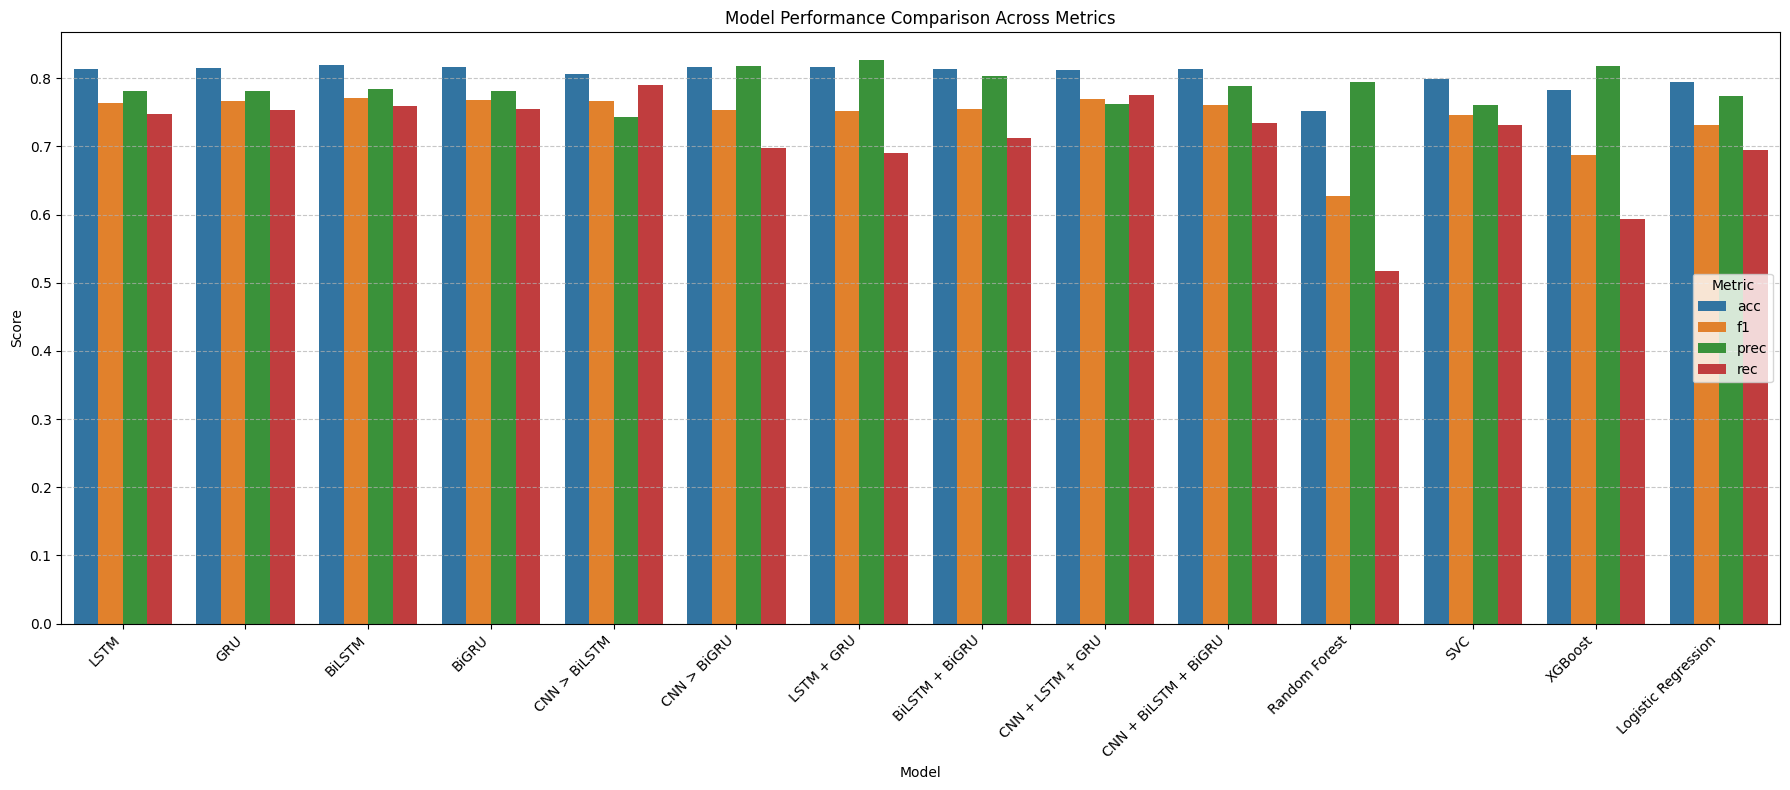

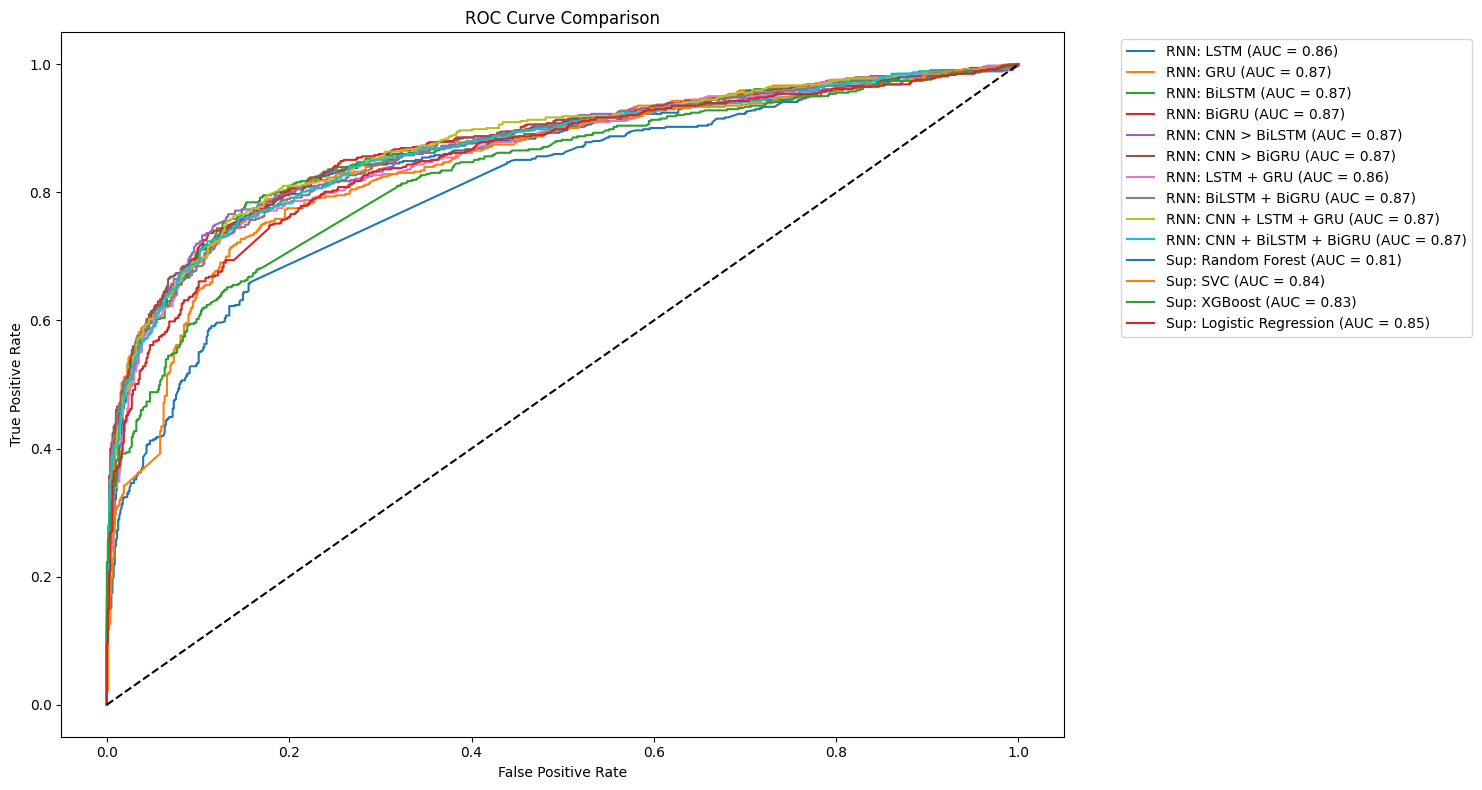

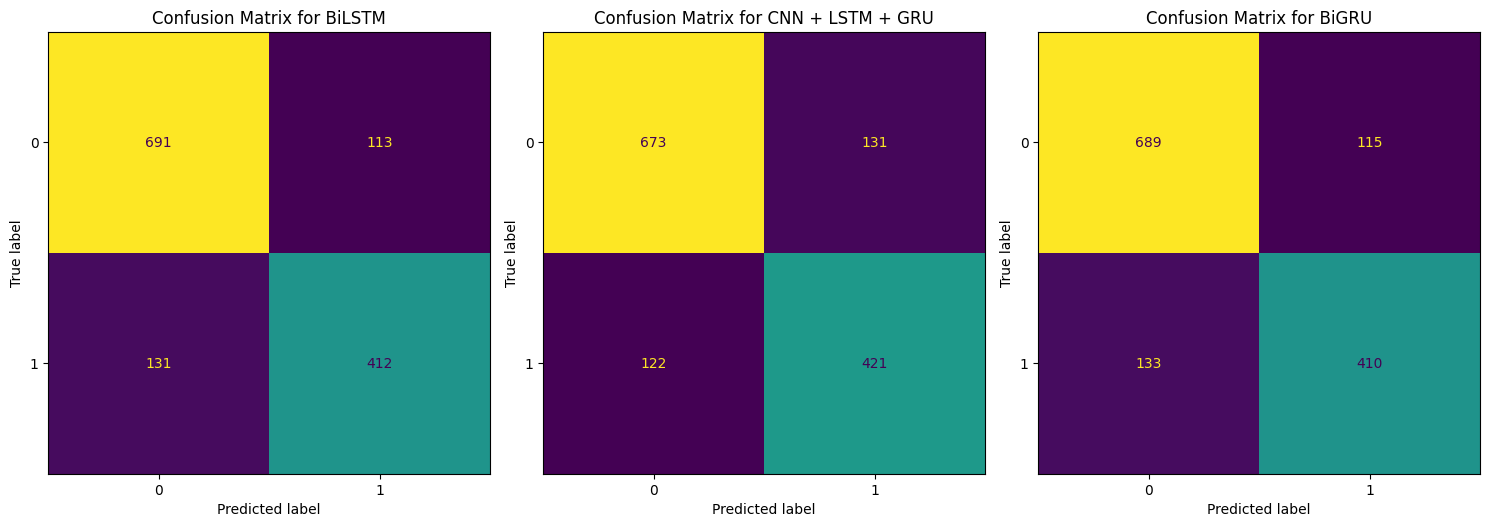

In [ ]:
# 1. Bar plot of metrics for all models

# Melt the combined DataFrame
all_results_melted = results_df.melt(id_vars='name',
                                     value_vars=['acc', 'f1', 'prec', 'rec'],
                                     var_name='Metric',
                                     value_name='Score')

# Create the grouped bar plot
plt.figure(figsize=(18, 8)) # Adjust figure size as needed
sns.barplot(x='name', y='Score', hue='Metric', data=all_results_melted)

plt.title('Model Performance Comparison Across Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.legend(title='Metric', loc='center right', bbox_to_anchor=(1, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.tight_layout() # Adjust layout
plt.show()

# 2. ROC Curve Plot
plt.figure(figsize=(15, 8))

# Plot ROC curves for RNN models
for index, row in rnn_results_df.iterrows():
    model = row['model']
    model_name = row['name']
    # Assuming X_val is the validation data for RNNs
    y_pred_proba = model.predict(X_val, verbose=0)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    auc = roc_auc_score(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'RNN: {model_name} (AUC = {auc:.2f})')

# Plot ROC curves for Supervised models
for index, row in sup_results_df.iterrows():
    model = row['model']
    model_name = row['name']
    # Assuming X_val_s is the validation data for supervised models
    # Check if the model has predict_proba (for probability estimates)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_val_s)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val_s, y_pred_proba)
        auc = roc_auc_score(y_val_s, y_pred_proba)
        plt.plot(fpr, tpr, label=f'Sup: {model_name} (AUC = {auc:.2f})')
    # Some models might have decision_function instead of predict_proba
    elif hasattr(model, 'decision_function'):
         y_pred_proba = model.decision_function(X_val_s)
         fpr, tpr, thresholds = roc_curve(y_val_s, y_pred_proba)
         auc = roc_auc_score(y_val_s, y_pred_proba)
         plt.plot(fpr, tpr, label=f'Sup: {model_name} (AUC = {auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside plot
plt.tight_layout()
plt.show()

In [45]:
# Find the model with the highest F1-score.
best_model = results_df.loc[results_df['f1'].idxmax()]

print(f"The best model is {best_model['name']}")

if best_model['name'] in rnn_models:
    y_pred = (best_model['model'].predict(X_val)>0.5).astype(int)
    print(classification_report(y_val, y_pred))
else:
    y_pred = (best_model['model'].predict(X_val_s)>0.5).astype(int)
    print(classification_report(y_val_s, y_pred))

The best model is BiLSTM
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       804
           1       0.78      0.76      0.77       543

    accuracy                           0.82      1347
   macro avg       0.81      0.81      0.81      1347
weighted avg       0.82      0.82      0.82      1347



# Conclusion

In this project, we focused on classifying tweets as either disaster-related or not using the Kaggle "Natural Language Processing with Disaster Tweets" dataset. Following initial data preparation, we extensively explored various deep learning Recurrent Neural Network (RNN) architectures and compared their performance to traditional supervised learning models.

Our analysis of the RNN models revealed a range of effectiveness, with the BiLSTM architecture demonstrating superior performance based on the F1-score and AUC metrics. This success is likely attributable to its bidirectional nature, which allows the model to capture contextual information from both preceding and succeeding words in a tweet, crucial for understanding nuances in natural language.

Comparing the RNN models to traditional supervised learning methods like Random Forest, SVC, XGBoost, and Logistic Regression highlighted the advantage of deep learning for this sequential text classification task. The RNN models, as a group, generally outperformed the traditional models, indicating their better ability to learn complex patterns and dependencies within the tweet data. While the SVC model was the best among the traditional methods, the leading RNN model, BiLSTM, still achieved a higher F1-score.

Despite achieving a respectable score on the Kaggle leaderboard, indicating good generalization to unseen data, there are limitations and areas for improvement. Our preprocessing, while effective, could be further refined, for instance, by exploring more advanced techniques for handling emojis or slang. In addition, while removing words that are common to both classes improved performance, it does result in a loss of information that could impact performance on unseen data.

Future work could involve experimenting with more sophisticated deep learning architectures, such as Transformer networks, which have shown state-of-the-art results in various NLP tasks. Additionally, incorporating external data sources or using pre-trained language models like BERT could potentially boost performance. Further hyperparameter tuning and cross-validation on a larger scale could also lead to some gains although extensive hyperparameter tuning using these architectures resulted in only marginal gains. Addressing the class imbalance with more advanced techniques than class weighting, might also yield improvements.